In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from time import time
tqdm.monitor_interval = 0
import torch
import json
import torch.nn as nn
import numpy as np
torch.manual_seed(0)
np.random.seed(0)

In [3]:
EPS = 120
LAG = 12
STOPS=5
SROUTE = SAMPLE_ROUTES[0]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device
SIND = 30

In [4]:
dset = SingleStop(
    SROUTE, SIND, 'train', 32, 
    lag=LAG, stops=STOPS).generator()
evalset = SingleStop(
    SROUTE, SIND, 'test', 32, 
    lag=LAG, stops=STOPS).generator()

Locals dataset: train (metadata/2h/M102_0.json)
 [*] Loaded routes: 1 (0.05s)
 [*] Has trainable inds: 54569
 [*] Subset train: 44084
 [*] Subset in Stop-30: 1060
Locals dataset: test (metadata/2h/M102_0.json)
 [*] Loaded routes: 1 (0.06s)
 [*] Has trainable inds: 54569
 [*] Subset test: 10485
 [*] Subset in Stop-30: 270


In [5]:
from models.Linear import Linear

In [6]:
# lag = 6th timestep is predicted based on past 5 (50 mins)
model = Linear(lag=5, stops=1).to(device)
model.device = device

In [7]:
criterion, opt, sch = model.params(lr=0.001)

In [8]:
# evaluate(evalset, model, crit=lambda _y, y: mape(tonpy(_y)[:, 0], tonpy(y)[:, 0]))
evaluate(evalset, model, crit=lambda _y, y: np.sqrt(criterion(_y[:, 0], y[:, 0]).item()))
evaluate(evalset, model, crit=lambda _y, y: criterion(_y[:, 0], y[:, 0]).item())

Eval loss: 6.1702 
Eval loss: 38.8181 


In [9]:
losses = []
eval_mse = []
eval_mape = []
from numpy.random import randint
for eii  in range(EPS):
    for bii, batch in enumerate(dset):
        model.train()
        Xs, Ys = model.format_batch(batch)
        
        outputs = model(Xs)

        opt.zero_grad()
        loss = criterion(outputs, Ys)
        loss.backward()
        losses.append(loss.item())
        opt.step()

        sys.stdout.write('[%d/%d : %d/%d] - L%.2f      \r' % (
            eii+1, EPS,
            bii+1, len(dset), 
            loss.item()
        ))
    sys.stdout.write('\n')

    eval_mse.append(
        evaluate(
            evalset, model, 
            crit=lambda y, _y: criterion(y[:, 0], _y[:, 0]).item(), result=True))
    sys.stdout.flush()
    sch.step()

[1/120 : 33/33] - L2.01      
Eval loss: 3.6365  
[2/120 : 33/33] - L3.06      
Eval loss: 3.3027 
[3/120 : 33/33] - L3.24      
Eval loss: 3.0269 
[4/120 : 33/33] - L1.77      
Eval loss: 2.8589 
[5/120 : 33/33] - L3.11      
Eval loss: 2.7125 
[6/120 : 33/33] - L2.67      
Eval loss: 2.6689 
[7/120 : 33/33] - L3.05      
Eval loss: 2.5257 
[8/120 : 33/33] - L1.91      
Eval loss: 2.4975 
[9/120 : 33/33] - L9.79      
Eval loss: 2.3952 
[10/120 : 33/33] - L1.57      
Eval loss: 2.4380 
[11/120 : 33/33] - L3.79      
Eval loss: 2.4272 
[12/120 : 33/33] - L3.79      
Eval loss: 2.3422 
[13/120 : 33/33] - L3.51       
Eval loss: 2.3785 
[14/120 : 33/33] - L4.30      
Eval loss: 2.2920 
[15/120 : 33/33] - L3.19      
Eval loss: 2.3192 
[16/120 : 33/33] - L5.13      
Eval loss: 2.3230 
[17/120 : 33/33] - L1.93      
Eval loss: 2.2882 
[18/120 : 33/33] - L2.85       
Eval loss: 2.2611 
[19/120 : 33/33] - L1.38      
Eval loss: 2.2564 
[20/120 : 33/33] - L1.46      
Eval loss: 2.2521 
[21/12

In [35]:
VIEW_LAG=96
viewset = SingleStop(
    SROUTE, SIND, 'test', 32, 
    lag=VIEW_LAG, stops=STOPS)
viewset = [viewset[ii] for ii in range(1)]

Locals dataset: test (metadata/16h/M102_0.json)
 [*] Loaded routes: 1 (0.00s)
 [*] Has trainable inds: 262
 [*] Subset test: 59
 [*] Subset in Stop-30: 1


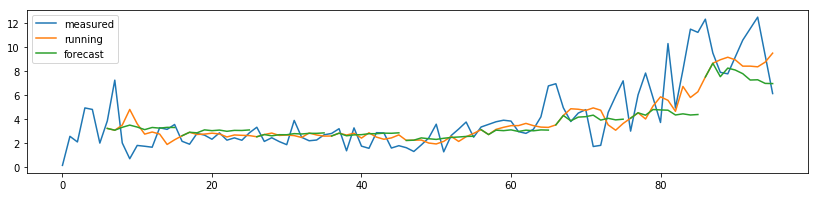

In [41]:
from utils import *
show_eval(viewset, model, fmax=10)

In [ ]:
kcast = 5
model.eval()
klosses = [list() for _ in range(kcast)]

for batch in evalset:
    Xs, Ys = model.format_batch(batch[:, :6, :])
    yinit = model(Xs)
    ycasts = [yinit.detach()] # k=1
    Xs = torch.cat([Xs, yinit], dim=1)
    xnext = Xs[:, -5:]
    for ki in range(1, kcast):
        ynext = model(xnext)
        ycasts.append(ynext)
        Xs = torch.cat([Xs, ynext], dim=1)
        xnext = Xs[:, -5:]
        
    Xs, _ = model.format_batch(batch[:, 6:])
    ypred, ytrue = torch.stack(ycasts, dim=1).squeeze(), Xs
    for ki in range(kcast):
        kmse = criterion(ypred[:, ki], ytrue[:, ki]).item()
        kmape = mape(tonpy(ypred[:, ki]), tonpy(ytrue[:, ki]))
        klosses[ki].append([kmse, kmape])
    
fcast = []
for ki in range(kcast):
    kmse, kmape = zip(*klosses[ki])
    kmse = np.mean(kmse)
    kmape = np.mean(kmape)
    fcast.append(dict(mse=kmse, mape=kmape))
    
print(kmse, kmape)
# with open('checkpoints/linear/%s.json' % name, 'w') as fl:
#     json.dump(dict(
#         mse=eval_mse,
#         mape=eval_mape,
#         fcast=fcast,
#     ), fl, indent=4)
